In [4]:
from DeepLabCutImplementation.model import PoseModel
from DeepLabCutImplementation.runners.train import PoseTrainingRunner
from DeepLabCutImplementation.runners.logger import CSVLogger
from DeepLabCutImplementation.runners.snapshots import TorchSnapshotManager

from DeepLabCutImplementation.data.utils import make_multianimal_labeled_image

from Wrappers.backbone import get_HRNetCoAM_backbone
from Wrappers.head import get_heatmap_head

from DeepLabCutImplementation.task import Task

import albumentations as A
from torch.utils.data import DataLoader
import torch
from torchvision.transforms import v2 as transforms

import logging
logging.getLogger().setLevel(logging.INFO)
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [5]:
backbone = {
    "num_joints": 17,
    "att_heads": 1,
    "channel_att_only": False,
    "coam_modules": (2, ),
    "selfatt_coam_modules": None,
    "pretrained":False
}

bodypart_head = {
    "num_joints": 17,
    "channels": [48],
    "kernel_sizes": [],
    "kernel_size_final": 1,
    "strides": []
}

model = PoseModel(
            backbone=get_HRNetCoAM_backbone(**backbone),
            heads={
                "bodypart": get_heatmap_head(**bodypart_head),
            }
        )

path_to_model_checkpoint = "snapshot-best.pt"
model.load_state_dict(torch.load(path_to_model_checkpoint, weights_only=True)['model'])
model.cuda()

PoseModel(
  (backbone): HRNetCoAM(
    (model): HighResolutionNetFeatures(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): I

In [6]:
inference_transforms = []

inference_transforms.append(
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )

inference_transforms = A.Compose(
        inference_transforms,
        keypoint_params=A.KeypointParams(
            "xy", remove_invisible=False, label_fields=["class_labels"]
        ),
        bbox_params=A.BboxParams(format="coco", label_fields=["bbox_labels"]),
        )

In [8]:
from DeepLabCutImplementation.data.cocoloader import COCOLoader

# Configuration required by BUCTD for top_down_cropping and gen_sampling.
data_config = {
        "bbox_margin": 25,
        "colormode": "RGB",
        "inference": {
            "multithreading": {
                "enabled": True,
                "queue_length": 4,
                "timeout": 30,
            },
            "top_down_crop": {
                "width": 256,
                "height": 256,
                "crop_with_context": True,
            }
        },
        "train": {
            "top_down_crop": {
                "width": 256,
                "height": 256,
                "crop_with_context": False,
            },
        },
        "gen_sampling": {
            "keypoint_sigmas": 0.1,
        }
    }

data_loader = COCOLoader(
    project_root = "dataset/ap-10k",
    data_config = data_config,
    train_json_filename = "ap10k-train-split1.json",
    test_json_filename = "ap10k-test-split1.json",
)

In [9]:
test_dataset = data_loader.create_dataset(transform=inference_transforms, mode="test", task=Task.COND_TOP_DOWN)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [10]:
runner = PoseTrainingRunner(
    model=model,
    optimizer=None,
    device="cuda",
    snapshot_manager=TorchSnapshotManager(
            snapshot_prefix="snapshot",
            model_folder=Path("training_logs/snapshots"),
            key_metric="test.mAP",
            key_metric_asc=True,
            max_snapshots=5,
            save_epochs=5,
            save_optimizer_state=False,
    ),
    eval_interval=1,
    scheduler=None,
    logger=CSVLogger(train_folder="training_logs", log_filename="training_log.csv"),
    load_weights_only=True,
)

In [ ]:
# Run evaluation on test set
runner._epoch(test_dataloader, mode="eval")

C:\Users\Peter Helf\AppData\Local\Temp\ipykernel_40916\793631976.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap("rainbow", num_pred),
C:\Users\Peter Helf\AppData\Local\Temp\ipykernel_40916\793631976.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap("rainbow", num_pred),


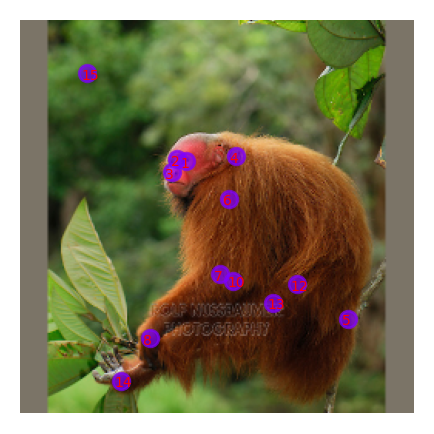

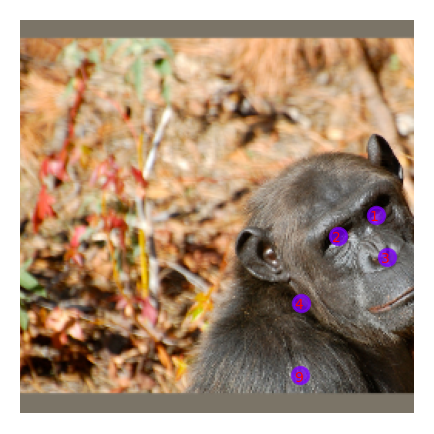

In [12]:
inv_normalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                 std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                 std = [ 1., 1., 1. ]),
                           ])

for i, batch in enumerate(test_dataloader):
    cond_kpts = batch["context"]["cond_keypoints"]

    outputs = model(batch["image"].cuda(), cond_kpts=cond_kpts)
    predictions = {
        name: {k: v.detach().cpu().numpy() for k, v in pred.items()}
        for name, pred in model.get_predictions(outputs).items()
    }

    ground_truth = batch["annotations"]["keypoints"]

    pred_bodyparts = predictions["bodypart"]["poses"][0]

    num_pred, num_keypoints = pred_bodyparts.shape[:2]

    frame = batch["image"][0]

    frame = inv_normalize(frame).permute(1,2,0)

    fig, ax = plt.subplots(frameon=False, dpi=200)
    ax.axis("off")
    ax.invert_yaxis()
    h, w, _ = np.shape(frame)
    fig.set_size_inches(w / 100, h / 100)
    ax.set_xlim(0, w)
    ax.set_ylim(0, h)
    ax.invert_yaxis()
    ax.imshow(frame, "gray")

    ax = make_multianimal_labeled_image(
            frame,
            ground_truth,
            pred_bodyparts[:, :, :2],
            pred_bodyparts[:,:,2:],
            plt.cm.get_cmap("rainbow", num_pred),
            12,
            0.7,
            0.1,
            ax=ax,
        )

    if i > 0:
        break